In [1]:
# ============================================================
# Cell 1 – Importuri & device
# ============================================================
import os
from pathlib import Path
import random

import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as T
import torchvision.models as models

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# reproducibilitate (nu e perfectă, dar ajută)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
# ============================================================
# Cell 2 – Explorare structură dataset
# ============================================================

print("La rădăcină /kaggle/input:", os.listdir("/kaggle/input"))

DATA_ROOT = Path("/kaggle/input/cbir-dataset")
print("La rădăcina cbir-dataset:", os.listdir(DATA_ROOT))

IMG_ROOT = DATA_ROOT / "dataset"
print("IMG_ROOT =", IMG_ROOT)

# primele câteva fișiere
for p in list(IMG_ROOT.glob("*.jpg"))[:10]:
    print(p)


La rădăcină /kaggle/input: ['cbir-dataset']
La rădăcina cbir-dataset: ['dataset']
IMG_ROOT = /kaggle/input/cbir-dataset/dataset
/kaggle/input/cbir-dataset/dataset/1269.jpg
/kaggle/input/cbir-dataset/dataset/3863.jpg
/kaggle/input/cbir-dataset/dataset/623.jpg
/kaggle/input/cbir-dataset/dataset/2193.jpg
/kaggle/input/cbir-dataset/dataset/3750.jpg
/kaggle/input/cbir-dataset/dataset/2008.jpg
/kaggle/input/cbir-dataset/dataset/2081.jpg
/kaggle/input/cbir-dataset/dataset/3919.jpg
/kaggle/input/cbir-dataset/dataset/3757.jpg
/kaggle/input/cbir-dataset/dataset/4489.jpg


In [3]:
# ============================================================
# Cell 3 – DataFrame cu căi de imagini (fără label-uri)
# ============================================================

image_paths = sorted(IMG_ROOT.glob("*.jpg"))
print("Număr imagini găsite:", len(image_paths))

df = pd.DataFrame({"path": image_paths})
df.head()


Număr imagini găsite: 4738


,path
0,/kaggle/input/cbir-dataset/dataset/0.jpg
1,/kaggle/input/cbir-dataset/dataset/1.jpg
2,/kaggle/input/cbir-dataset/dataset/10.jpg
3,/kaggle/input/cbir-dataset/dataset/100.jpg
4,/kaggle/input/cbir-dataset/dataset/1000.jpg


In [5]:
# ============================================================
# Cell 4 – Împărțire train / val
# ============================================================

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)

len(train_df), len(val_df)


(3790, 948)

In [7]:
# ============================================================
# Cell 5 – Transformări (augmentări pentru train)
# ============================================================

train_transform = T.Compose([
    T.Resize(256),
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


In [8]:
# ============================================================
# Cell 6 – Dataset pentru rețea siameză (self-supervised)
# Pozitiv: două augmentări ale ACELEIAȘI imagini
# Negativ: imagini diferite (al doilea index random)
# ============================================================

class SiameseDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img1_path = self.df.loc[idx, "path"]

        # 1 = pereche pozitivă (aceeași imagine), 0 = negativă (imagine diferită)
        same_image = random.randint(0, 1)

        if same_image == 1:
            img2_path = img1_path
            target = 1.0
        else:
            idx2 = idx
            while idx2 == idx:
                idx2 = random.randint(0, len(self.df) - 1)
            img2_path = self.df.loc[idx2, "path"]
            target = 0.0

        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        target = torch.tensor([target], dtype=torch.float32)
        return img1, img2, target


In [9]:
# ============================================================
# Cell 7 – DataLoader-e
# ============================================================

batch_size = 32

train_dataset = SiameseDataset(train_df, transform=train_transform)
val_dataset   = SiameseDataset(val_df,   transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)

len(train_loader), len(val_loader)


(119, 30)

In [11]:
# ============================================================
# Cell 8 – Rețeaua de embedding (ResNet18 pre-antrenat)
# ============================================================

class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        # compatibilitate pentru versiuni diferite de torchvision
        try:
            weights = models.ResNet18_Weights.IMAGENET1K_V1
            self.backbone = models.resnet18(weights=weights)
        except AttributeError:
            self.backbone = models.resnet18(pretrained=True)

        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, embedding_dim)

    def forward(self, x):
        x = self.backbone(x)
        # L2-normalizare -> vectorii stau pe sferă; util pt cosine / L2
        x = F.normalize(x, p=2, dim=1)
        return x


class SiameseNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.embedding_net = EmbeddingNet(embedding_dim)

    def forward(self, x1, x2):
        z1 = self.embedding_net(x1)
        z2 = self.embedding_net(x2)
        return z1, z2


In [12]:
# ============================================================
# Cell 9 – Contrastive loss
# ============================================================

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, z1, z2, y):
        # z1, z2: [B, D], y: [B, 1] (1 = similar, 0 = diferit)
        distances = F.pairwise_distance(z1, z2)  # [B]
        y = y.view(-1)  # [B]

        loss_pos = y * distances.pow(2)
        loss_neg = (1 - y) * F.relu(self.margin - distances).pow(2)

        loss = (loss_pos + loss_neg).mean()
        return loss


In [13]:
# ============================================================
# Cell 10 – Instanțiere model + optimizator
# ============================================================

model = SiameseNet(embedding_dim=128).to(device)
criterion = ContrastiveLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]


SiameseNet(
  (embedding_net): EmbeddingNet(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (

In [15]:
# ============================================================
# Cell 11 – Funcții pentru un epoch de train / val
# ============================================================

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for img1, img2, target in loader:
        img1 = img1.to(device)
        img2 = img2.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        z1, z2 = model(img1, img2)
        loss = criterion(z1, z2, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    for img1, img2, target in loader:
        img1 = img1.to(device)
        img2 = img2.to(device)
        target = target.to(device)

        z1, z2 = model(img1, img2)
        loss = criterion(z1, z2, target)
        running_loss += loss.item()

    return running_loss / len(loader)


In [16]:
# ============================================================
# Cell 12 – Loop de antrenare (poți crește num_epochs)
# ============================================================

num_epochs = 5

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss   = eval_one_epoch(model, val_loader,   criterion, device)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"- train loss: {train_loss:.4f}  |  val loss: {val_loss:.4f}")


Epoch [1/5] - train loss: 0.0631  |  val loss: 0.0170
Epoch [2/5] - train loss: 0.0397  |  val loss: 0.0162
Epoch [3/5] - train loss: 0.0344  |  val loss: 0.0120
Epoch [4/5] - train loss: 0.0299  |  val loss: 0.0108
Epoch [5/5] - train loss: 0.0305  |  val loss: 0.0101


In [17]:
# ============================================================
# Cell 13 – Funcție pentru a calcula embedding-uri pentru TOATE imaginile
# ============================================================

@torch.no_grad()
def compute_embeddings(model, df, transform, device, batch_size=64):
    model.eval()
    all_embeddings = []

    for start in range(0, len(df), batch_size):
        batch_paths = df["path"].iloc[start:start+batch_size].tolist()
        imgs = []
        for p in batch_paths:
            img = Image.open(p).convert("RGB")
            imgs.append(transform(img))
        imgs = torch.stack(imgs).to(device)

        z = model.embedding_net(imgs)  # [B, D]
        all_embeddings.append(z.cpu())

    all_embeddings = torch.cat(all_embeddings, dim=0)  # [N, D]
    return all_embeddings

# calculează embedding-uri pentru TOATĂ baza de date (train + val)
full_df = pd.concat([train_df, val_df], ignore_index=True)
db_embeddings = compute_embeddings(model, full_df, val_transform, device, batch_size=64)
db_embeddings.shape


torch.Size([4738, 128])

In [19]:
# ============================================================
# Cell 14 – Salvarea embedding-urilor (opțional, pt. reuse)
# ============================================================

torch.save(db_embeddings, "cbir_embeddings.pt")
full_df.to_csv("cbir_image_paths.csv", index=False)

# în Kaggle, fișierele apar în /kaggle/working și pot fi "Download" din Files


In [20]:
# ============================================================
# Cell 15 – Funcție de căutare imagini similare + vizualizare
# query_idx = index în full_df
# ============================================================

@torch.no_grad()
def show_similar(query_idx, top_k=5):
    model.eval()

    query_path = full_df.loc[query_idx, "path"]
    query_img = Image.open(query_path).convert("RGB")

    # embedding pentru imaginea query
    query_tensor = val_transform(query_img).unsqueeze(0).to(device)
    query_emb = model.embedding_net(query_tensor).cpu()  # [1, D]

    # distanțe L2 față de toată baza
    dists = torch.cdist(query_emb, db_embeddings, p=2).squeeze(0)  # [N]

    # sortare crescătoare (distanță mică = mai similar)
    sorted_indices = torch.argsort(dists)

    # vom afișa query + top_k rezultate (sărind peste identitatea perfectă)
    plt.figure(figsize=(3 * (top_k + 1), 4))

    # afisăm imaginea query
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(query_img)
    plt.axis("off")
    plt.title("Query")

    col = 2
    for idx in sorted_indices:
        idx = idx.item()
        # sărim peste exact aceeași imagine (dacă apare prima)
        if idx == query_idx:
            continue

        res_path = full_df.loc[idx, "path"]
        res_img = Image.open(res_path).convert("RGB")

        plt.subplot(1, top_k + 1, col)
        plt.imshow(res_img)
        plt.axis("off")
        plt.title(f"Rank {col-1}")
        col += 1

        if col > top_k + 1:
            break

    plt.tight_layout()
    plt.show()


Query index: 244  | path: /kaggle/input/cbir-dataset/dataset/4194.jpg


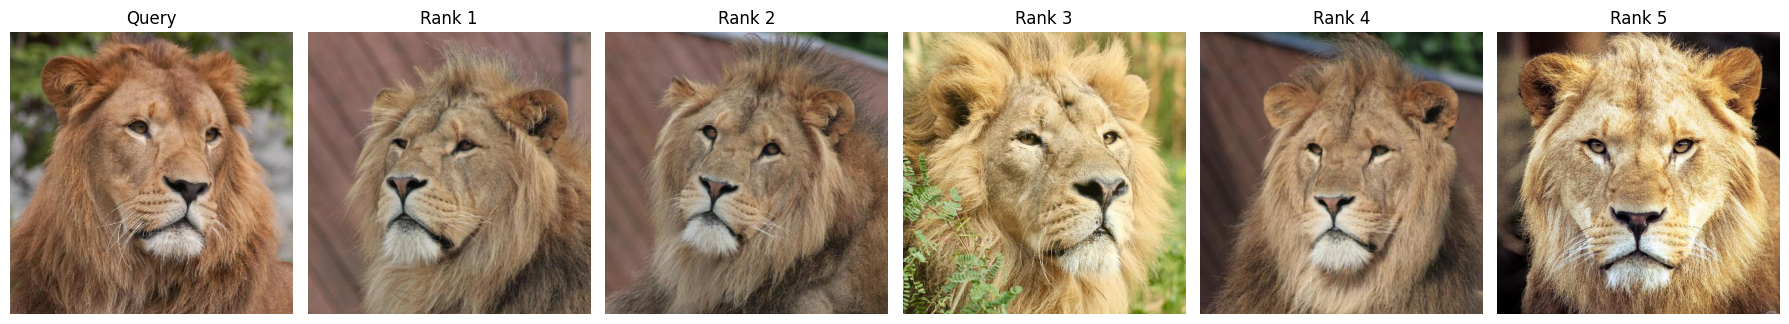

In [32]:
# ============================================================
# Cell 16 – Test: afișează imagini similare pentru un index random
# ============================================================

random_idx = random.randint(0, len(full_df) - 1)
print("Query index:", random_idx, " | path:", full_df.loc[random_idx, "path"])

show_similar(random_idx, top_k=5)
